KTK's main data structure: TimeSeries
=============================

The TimeSeries class is the basis of most ktk modules and is the only "new" class ktk users have to learn.

------------------------

***The three roles of the TimeSeries class are to:***

1. *organize multidimensional data in time;*
2. *deal with events;*
3. *associate metadata to data.*

------------------------

This class is largely inspired by Matlab's `timeseries` and `tscollection`. To better understand the role and capabilities of the TimeSeries class, we will begin by opening some columns of a csv file as a Pandas DataFrame. This file contains forces and moments applied on an instrumented wheelchair wheel during the propulsion of a manual wheelchair.

In [1]:
import ktk
import pandas as pd
import numpy as np

In [2]:
# Read some columns
df = pd.read_csv('data/timeseries/smartwheel.csv',
                 usecols=[18, 19, 20, 21, 22, 23],
                 names=['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz'],
                 nrows=5000)

# Assign time to the DataFrame's index, where the sampling rate is 240 Hz.
df.index = np.arange(df.shape[0]) / 240
df

,Fx,Fy,Fz,Mx,My,Mz
0.000000,1.27,-0.89,-0.20,-0.03,0.05,-0.03
0.004167,0.49,-0.83,-0.51,0.02,-0.01,-0.13
0.008333,0.00,-0.78,-0.51,0.04,-0.07,-0.18
0.012500,-0.13,-0.93,-0.41,0.03,-0.16,-0.18
0.016667,-0.02,-0.89,0.00,0.01,-0.21,-0.13
...,...,...,...,...,...,...
20.812500,0.87,-1.73,0.00,0.08,-0.07,-0.03
20.816667,0.68,-2.38,0.20,0.07,-0.05,0.08
20.820833,0.39,-2.72,0.20,0.02,0.00,0.10
20.825000,0.32,-2.51,0.41,0.04,0.05,0.08


Now, we can convert this DataFrame to a TimeSeries:

In [3]:
ts = ktk.TimeSeries.from_dataframe(df)
ts

TimeSeries with attributes:
             data: <dict with 6 entries>,
        data_info: <dict with 0 entries>,
           events: <list of 0 items>,
             time: <array of shape (5000,)>,
        time_info: <dict with 1 entries>

Properties
----------

### time and data ###

The `time` property is the time vector, which tells at which time correspond each of the samples.

In [4]:
ts.time

array([ 0.        ,  0.00416667,  0.00833333, ..., 20.82083333,
       20.825     , 20.82916667])

The `data` property contains the TimeSeries' data in a dictionary. Each of the 6 DataFrame's columns now corresponds to a data key.

In [5]:
ts.data

{
      'Fx': <array of shape (5000,)>,
      'Fy': <array of shape (5000,)>,
      'Fz': <array of shape (5000,)>,
      'Mx': <array of shape (5000,)>,
      'My': <array of shape (5000,)>,
      'Mz': <array of shape (5000,)>
}

In reality, Fx, Fy and Fz are components of a single entity which is a force vector. Similarly, Mx, My and Mz are components of a single entity which is a moment vector. Let's see what happens if we name the DataFrames' columns differently.

In [6]:
df.columns = ['Forces[0]', 'Forces[1]', 'Forces[2]', 'Moments[0]', 'Moments[1]', 'Moments[2]']
df

,Forces[0],Forces[1],Forces[2],Moments[0],Moments[1],Moments[2]
0.000000,1.27,-0.89,-0.20,-0.03,0.05,-0.03
0.004167,0.49,-0.83,-0.51,0.02,-0.01,-0.13
0.008333,0.00,-0.78,-0.51,0.04,-0.07,-0.18
0.012500,-0.13,-0.93,-0.41,0.03,-0.16,-0.18
0.016667,-0.02,-0.89,0.00,0.01,-0.21,-0.13
...,...,...,...,...,...,...
20.812500,0.87,-1.73,0.00,0.08,-0.07,-0.03
20.816667,0.68,-2.38,0.20,0.07,-0.05,0.08
20.820833,0.39,-2.72,0.20,0.02,0.00,0.10
20.825000,0.32,-2.51,0.41,0.04,0.05,0.08


Now we convert this DataFrame to a TimeSeries:

In [7]:
ts = ktk.TimeSeries.from_dataframe(df)
ts.data

{
       'Forces': <array of shape (5000, 3)>,
      'Moments': <array of shape (5000, 3)>
}

Instead of being separated into 6 separate components, the three components of both the forces and moments are now grouped in two Nx3 arrays. This may greatly simplify subsequent data processing. For example, if we are interested in calculating the vectorial sum of the forces, then one could add this new data to the TimeSeries with this line:

In [8]:
ts.data['Ftot'] = np.sqrt(np.sum(ts.data['Forces'] ** 2, axis=1))
ts.data

{
       'Forces': <array of shape (5000, 3)>,
         'Ftot': <array of shape (5000,)>,
      'Moments': <array of shape (5000, 3)>
}

### time_info and data_info ###

The `time_info` property associates metadata to the time vector. It is a dictionary where each key is the name of one metadata. By default, `time_info` includes the `Unit` metadata, which corresponds to `s`. Any other metadata can be added by adding new keys in `time_info`.

In [9]:
ts.time_info

{
      'Unit': 's'
}

Similarly, the `data_info` property associates metadata to data. This property is a dictionary of dictionaries, where the first key corresponds to the data key, and the second key is the metadata.

The `add_data_info` method eases the management of `data_info`.

In [10]:
ts.add_data_info('Forces', 'Unit', 'N')
ts.add_data_info('Moments', 'Unit', 'Nm')
ts.add_data_info('Ftot', 'Unit', 'N')

Unless explicitly mentioned, metadata is not used for calculation. It is rather a way to clarify the data by adding information to it. Some ktk functions however read those metadata: for example, the `TimeSeries.plot` method looks for `Unit` information and print it on the y axis.

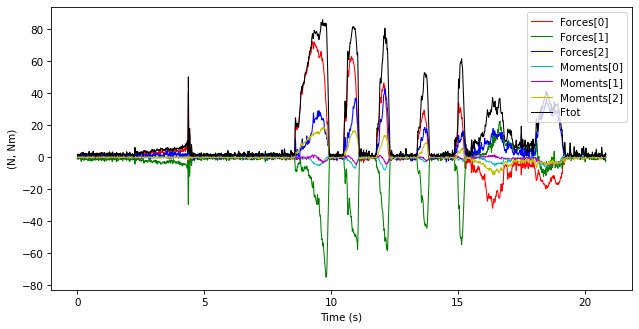

In [11]:
ts.plot()

### events ###

In the figure above, we see that the TimeSeries has cyclic information that could be characterized by events. A first spike was generated at about 4 seconds: this event corresponds to a synchronization signal that we generated by gently impacting the instrumented pushrim. Then, we see a series of pushes and recoveries. For now, we will add these events in the TimeSeries by hand.

In [12]:
ts.add_event(4.35, 'sync')
ts.add_event(8.56, 'push')
ts.add_event(9.93, 'recovery')
ts.add_event(10.50, 'push')
ts.add_event(11.12, 'recovery')
ts.add_event(11.78, 'push')
ts.add_event(12.33, 'recovery')
ts.add_event(13.39, 'push')
ts.add_event(13.88, 'recovery')
ts.add_event(14.86, 'push')
ts.add_event(15.30, 'recovery')

These events are now added to the TimeSeries' list of events:

In [13]:
ts.events

[[4.35, 'sync'],
 [8.56, 'push'],
 [9.93, 'recovery'],
 [10.5, 'push'],
 [11.12, 'recovery'],
 [11.78, 'push'],
 [12.33, 'recovery'],
 [13.39, 'push'],
 [13.88, 'recovery'],
 [14.86, 'push'],
 [15.3, 'recovery']]

If we plot again the TimeSeries, we can see the added events.

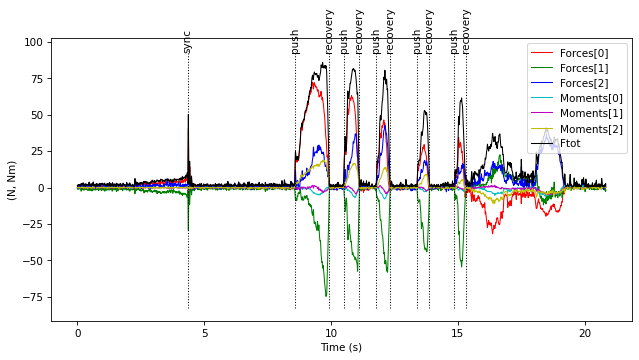

In [14]:
ts.plot()

Using events to synchronize TimeSeries
--------------------------------------

Let's see how we can make use of these events. First, the `sync` event can be used to set the zero-time, in the case where, for example, this wheel must be synchronized with another wheel, or with another instrument that also has a synchronization event. The method `sync_event` shifts the TimeSeries' time and events time so that the sync event becomes the new "zero-time".

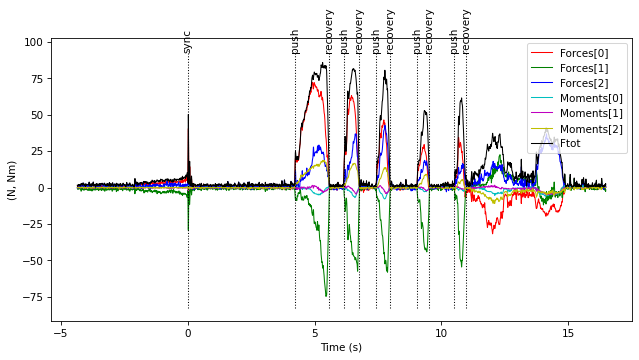

In [15]:
ts.sync_event('sync')
ts.plot()

Using events to extract sub-TimeSeries
--------------------------------------

The `TimeSeries` class comes with a myriad of methods such as `get_ts_after_event`, `get_ts_between_events`, etc. For example, if we want to analyze data of the four first pushes and get rid of any other data, we could extract a new TimeSeries that contains only these data:

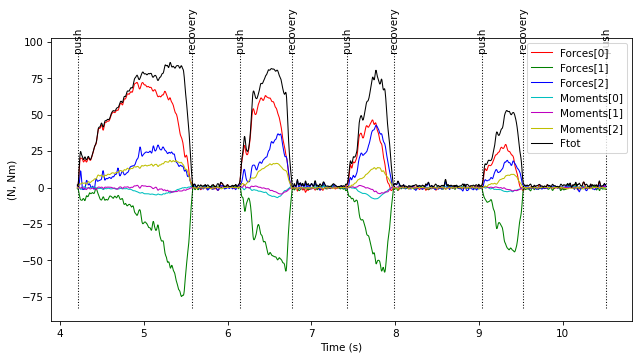

In [16]:
# Extract data push event 0 up to push event 4.
ts2 = ts.get_ts_between_events('push', 'push', 0, 4, inclusive=True)

# Remove the events that are not contained into the new time range.
ts2.trim_events()

ts2.plot()

Subsetting and merging timeseries
---------------------------------

We can use the `get_subset` method to extract some signals from a TimeSeries. For example, if we only want to keep force information and get rid of the moments:

In [17]:
ts3 = ts2.get_subset(['Forces', 'Ftot'])

ts3.data

{
      'Forces': <array of shape (1514, 3)>,
        'Ftot': <array of shape (1514,)>
}

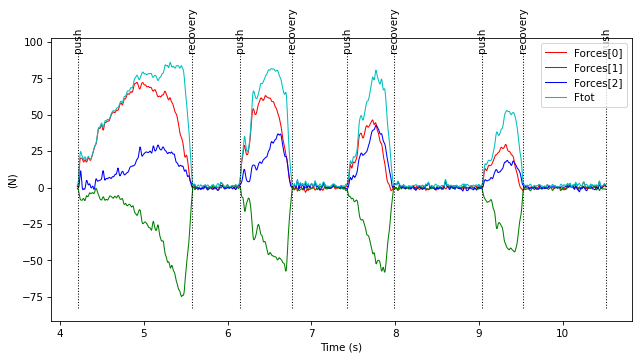

In [18]:
ts3.plot()

Using python's list comprehension is a nice way to extract a TimeSeries subset based on a selection criterion. For example, we could have obtained `ts3` by selecting every data key that begins with the letter 'F':

In [19]:
ts3 = ts2.get_subset([key for key in ts2.data if key.startswith('F')])

ts3.data

{
      'Forces': <array of shape (1514, 3)>,
        'Ftot': <array of shape (1514,)>
}

For more information on the TimeSeries class, please refer to the [API reference](api/ktk/timeseries.html).